## Import

In [323]:
import numpy as np
import cv2
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')
from ipywidgets import interact, interactive, fixed, interact_manual

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression



## Functions

In [324]:

def rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def uint8ify(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return np.uint8(img)

def overlay(a,b):
    # a and b should be float images and between 0-1

    mask = a >= 0.5 # generate boolean mask of everywhere a > 0.5 
    ab = np.zeros_like(a) # generate an output container for the blended image 

    # now do the blending 
    ab[~mask] = (2*a*b)[~mask] # 2ab everywhere a<0.5
    ab[mask] = (1-2*(1-a)*(1-b))[mask] # else this
    
    return ab

def disp(img, title='', s=12, vmin=None, vmax=None, write=False, file_name=None):
    plt.figure(figsize=(s,s))
    plt.axis('off')
    if vmin is not None and vmax is not None:
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    if write and file_name is not None:
        plt.savefig(file_name)
    plt.show()
    
def before_after(img_a, img_b, name="", vmin=None, vmax=None, effect_name="Processed"):
    fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,4))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f"{name} Original")
    axs[1].set_title(f"{name} {effect_name}")
    if vmin is not None and vmax is not None:
        axs[0].imshow(img_a, cmap='gray', vmin=vmin, vmax=vmax)
        axs[1].imshow(img_b, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs[0].imshow(img_a, cmap='gray')
        axs[1].imshow(img_b, cmap='gray')
    plt.show()


## Loading Images

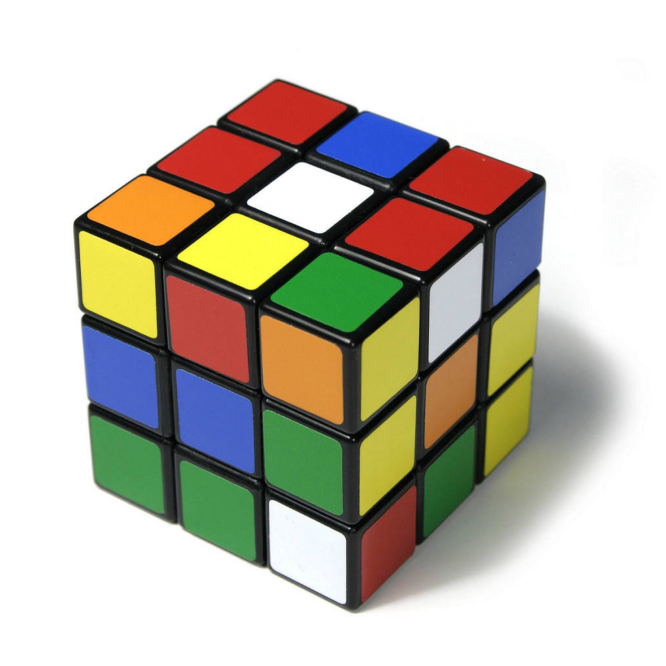

In [325]:
img_1 = rgb(cv2.imread("input/rubiks1_nologo.jpg"))
img_2 = rgb(cv2.imread("input/rubiks2.png"))
img_3 = rgb(cv2.imread("input/rubiks3.jpg"))
img_4 = rgb(cv2.imread("input/rubiks4.jpg"))
img_5 = rgb(cv2.imread("input/rubiks5.jpg"))

img_1_gray = cv2.imread("input/rubiks1_nologo.jpg", 0)
img_2_gray = cv2.imread("input/rubiks2.png", 0)
img_3_gray = cv2.imread("input/rubiks3.jpg", 0)
img_4_gray = cv2.imread("input/rubiks4.jpg", 0)
img_5_gray = cv2.imread("input/rubiks5.jpg", 0)

disp(img_1)

## Find Lines

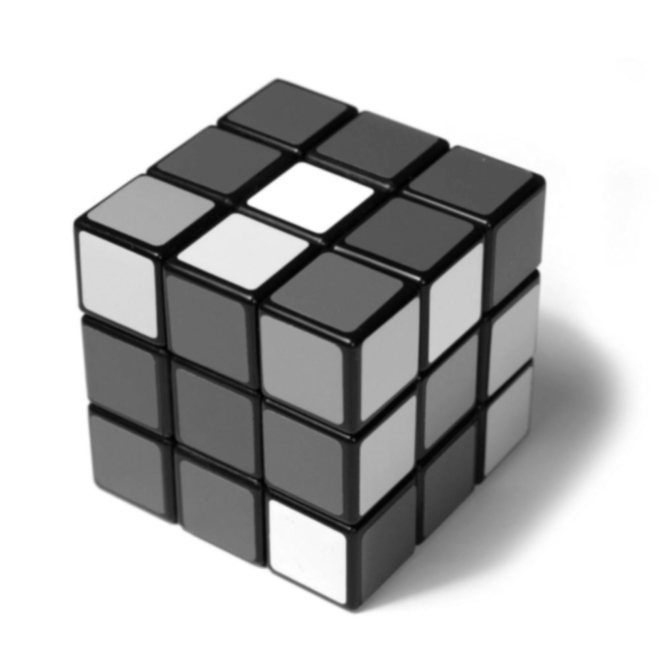

In [326]:
kernel_size = 7
blur_gray = cv2.GaussianBlur(img_1_gray,(kernel_size, kernel_size),0)
disp(blur_gray)

In [327]:
@interact(low_threshold=(0, 200, 1), high_threshold=(0, 200, 1))
def f(low_threshold = 160, high_threshold = 180):
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    disp(edges)

interactive(children=(IntSlider(value=160, description='low_threshold', max=200), IntSlider(value=180, descrip…

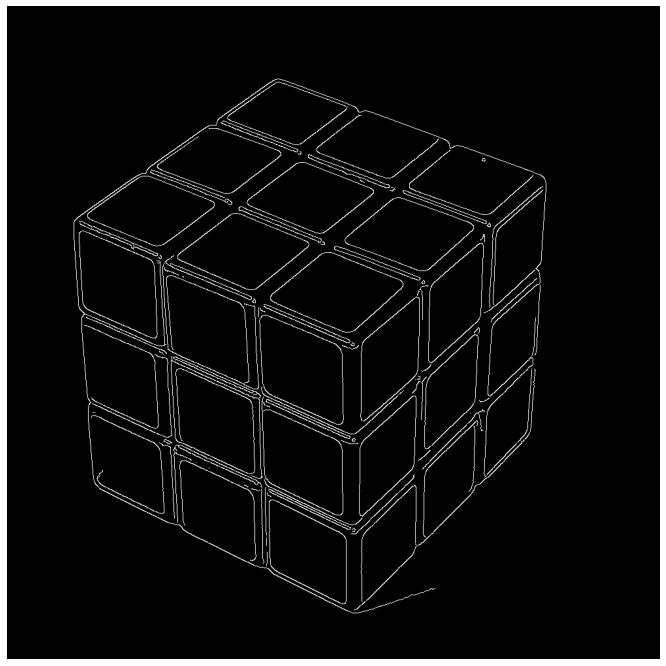

In [328]:
edges = cv2.Canny(blur_gray, 0, 75)
disp(edges)

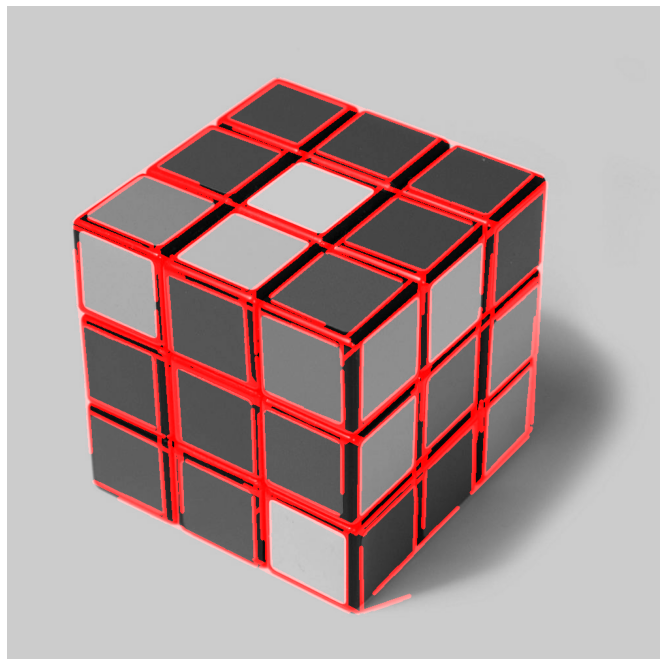

In [329]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img_1) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

angles = []
for line in lines:
    for x1,y1,x2,y2 in line:
        angle = cv2.fastAtan2(float(y2-y1), float(x2-x1))
        if angle >= 180:
            angle -= 180
        angles.append(angle)
        # print(angle)
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

# Draw the lines on the  image
img_1_gray_rgb = np.repeat(img_1_gray[:,:,None], 3, 2)
lines_edges = cv2.addWeighted(img_1_gray_rgb, 0.8, line_image, 1, 0)

disp(lines_edges)

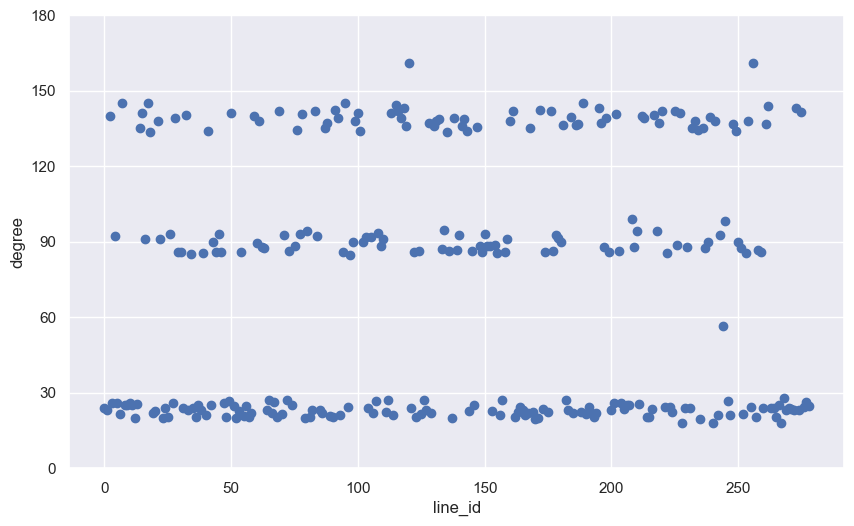

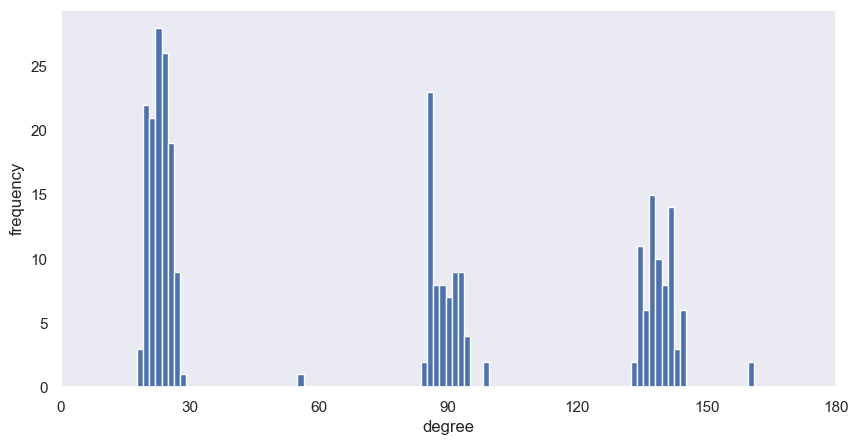

In [330]:
angles = np.array(angles)
plt.figure(figsize=(10,6), dpi=100)
plt.scatter(np.arange(len(angles)), angles)
plt.yticks(np.arange(0, 181, step=30))
plt.grid(True)
plt.ylabel("degree")
plt.xlabel("line_id")
plt.show()

plt.figure(figsize=(10,5), dpi=100)
plt.hist(angles.ravel(), bins=100)
plt.xticks(np.arange(0, 181, step=30))
plt.ylabel("frequency")
plt.xlabel("degree")
plt.show()

## Find breaking angles

In [331]:
angle_limits = [0,60,120,180]
rotation_angles = [0, 60, 120]

angles_clustering = KMeans(n_clusters=3, n_init=2)
angles_clustering.fit(angles.reshape(-1,1))
sorted_centers = sorted(angles_clustering.cluster_centers_)

angle_limits[1] = ((sorted_centers[0] + sorted_centers[1]) // 2)[0]
angle_limits[2] = ((sorted_centers[1] + sorted_centers[2]) // 2)[0]

rotation_angles[0] = -(90 - sorted_centers[1])[0] # vertical
rotation_angles[1] = -(90 - sorted_centers[0])[0] # positive
rotation_angles[2] = -(90 - sorted_centers[2])[0] # negative

print("> Cluster centers:")
print([int(center[0]) for center in sorted_centers], end="\n\n")
print("> Breaking angles:")
print(angle_limits, end="\n\n")
print("> Rotation angles:")
print(rotation_angles)

> Cluster centers:
[22, 88, 139]

> Breaking angles:
[0, 55.0, 114.0, 180]

> Rotation angles:
[-1.3565087514380707, -67.02122478337253, 49.48522037654726]


## Seperate Lines by direction

In [332]:
colors = [
    (245, 0, 87), #rgb(245, 0, 87)
    (0, 230, 118), #rgb(0, 230, 118)
    (25, 118, 210), #rgb(25, 118, 210)
    (245, 124, 0), #rgb(245, 124, 0)
    (124, 77, 255) #rgb(124, 77, 255)
]

colors_01 = [
    (245/255, 0/255, 87/255), #rgb(245, 0, 87)
    (0/255, 230/255, 118/255), #rgb(0, 230, 118)
    (25/255, 118/255, 210/255), #rgb(25, 118, 210)
    (245/255, 124/255, 0/255), #rgb(245, 124, 0)
    (124/255, 77/255, 255/255) #rgb(124, 77, 255)
]

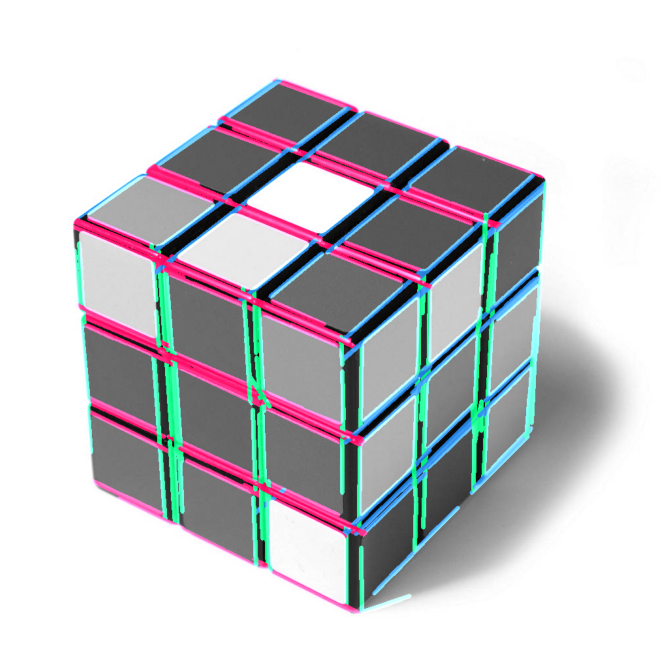

In [333]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img_1) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

angles = []
vertical_lines = []
negative_lines = []
positive_lines = []

for idx, line in enumerate(lines):
    for x1,y1,x2,y2 in line:
        angle = cv2.fastAtan2(float(y2-y1), float(x2-x1))
        if angle>=180:
            angle -= 180
        angles.append(angle)

        if angle_limits[0]<=angle<=angle_limits[1]:
            cluster_id = 0
            positive_lines.append([x1,y1,x2,y2])
        if angle_limits[1]<=angle<=angle_limits[2]:
            cluster_id = 1
            vertical_lines.append([x1,y1,x2,y2])
        if angle_limits[2]<=angle<=angle_limits[3]:
            cluster_id = 2
            negative_lines.append([x1,y1,x2,y2])
            
        cv2.line(line_image,(x1,y1),(x2,y2),colors[cluster_id],5)

# Draw the lines on the  image
img_1_gray_rgb = np.repeat(img_1_gray[:,:,None], 3, 2)
lines_edges = cv2.addWeighted(img_1_gray_rgb, 1, line_image, 1, 0)

disp(lines_edges)

In [334]:
# angles = np.array(angles)
# plt.figure(figsize=(8, 6), dpi=100)
# plt.scatter(np.arange(len(angles)), angles)
# plt.yticks(np.arange(0, 181, step=30))
# plt.grid(True)
# plt.ylabel("degree")
# plt.xlabel("line_id")
# plt.show()

# plt.figure(figsize=(10,5))
# plt.hist(angles.ravel(), bins=100)
# plt.xticks(np.arange(0, 181, step=30))
# plt.ylabel("frequency")
# plt.xlabel("degree")
# plt.show()

## Line types

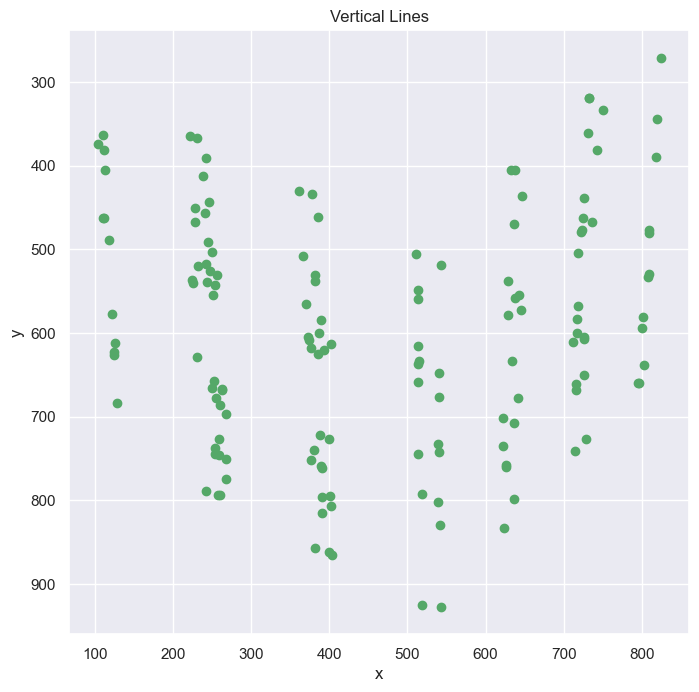

In [335]:
# vertical lines
points1 = np.zeros((len(vertical_lines)*2, 2))
for i in range(len(vertical_lines)):
    # point A on a line
    points1[2*i][0] = (vertical_lines[i][0])
    points1[2*i][1] = (vertical_lines[i][1])
    # point B on a line
    points1[2*i+1][0] = (vertical_lines[i][2])
    points1[2*i+1][1] = (vertical_lines[i][3])

    
plt.figure(figsize=(8,8), dpi=100)
plt.title("Vertical Lines")
plt.scatter(points1[:,0], points1[:,1], c='g')
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylabel("y")
plt.xlabel("x")
plt.show()

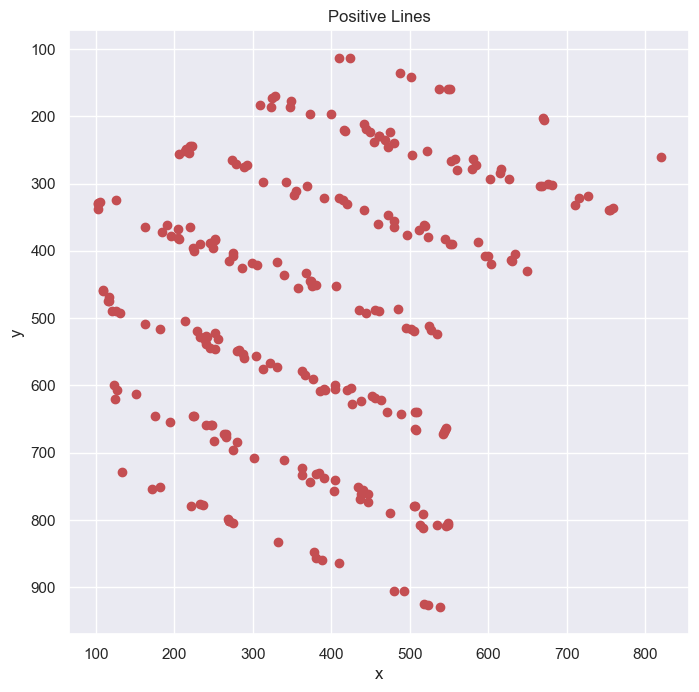

In [336]:
# positive lines
points2 = np.zeros((len(positive_lines)*2, 2))
for i in range(len(positive_lines)):
    # point A on a line
    points2[2*i][0] = (positive_lines[i][0])
    points2[2*i][1] = (positive_lines[i][1])
    # point B on a line
    points2[2*i+1][0] = (positive_lines[i][2])
    points2[2*i+1][1] = (positive_lines[i][3])
    
plt.figure(figsize=(8,8), dpi=100)
plt.title("Positive Lines")
plt.scatter(points2[:,0], points2[:,1], c='r')
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylabel("y")
plt.xlabel("x")
plt.show()

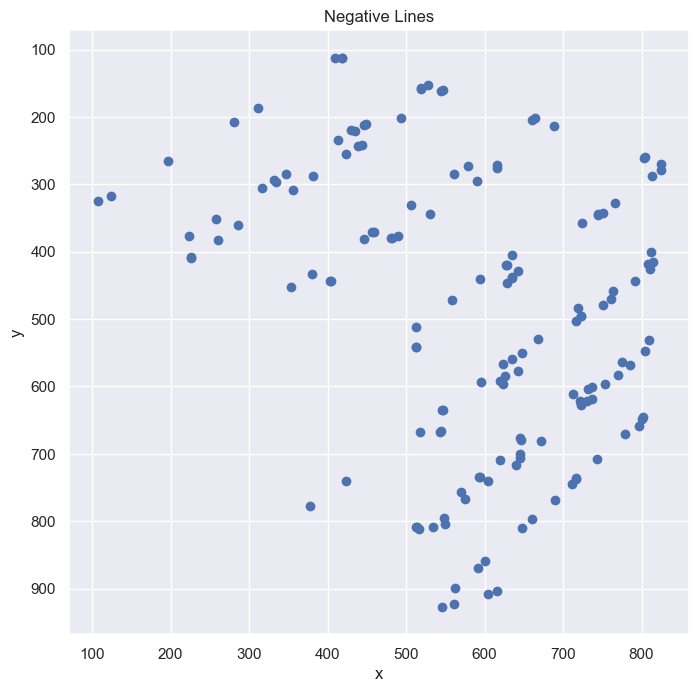

In [337]:
# vertical lines
points3 = np.zeros((len(negative_lines)*2, 2))
for i in range(len(negative_lines)):
    # point A on a line
    points3[2*i][0] = (negative_lines[i][0])
    points3[2*i][1] = (negative_lines[i][1])
    # point B on a line
    points3[2*i+1][0] = (negative_lines[i][2])
    points3[2*i+1][1] = (negative_lines[i][3])
    
plt.figure(figsize=(8,8), dpi=100)
plt.title("Negative Lines")
plt.scatter(points3[:,0], points3[:,1])
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylabel("y")
plt.xlabel("x")
plt.show()

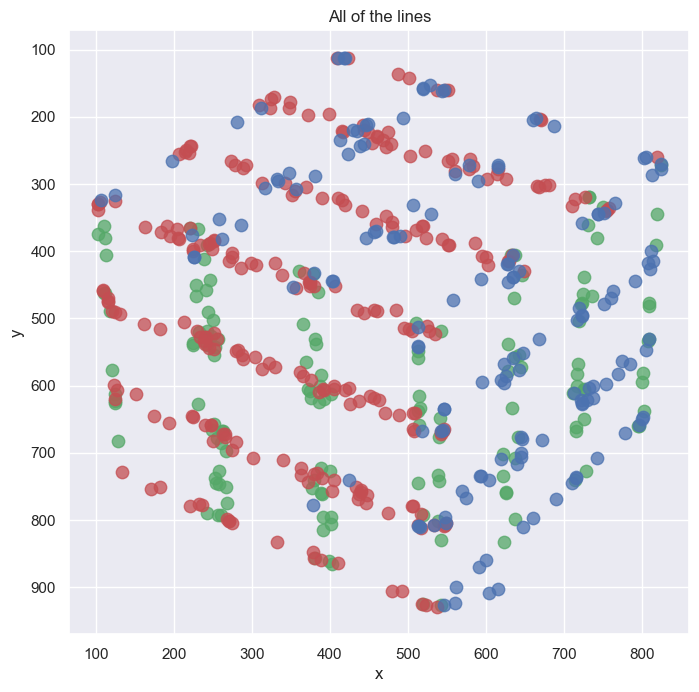

In [338]:
plt.figure(figsize=(8,8), dpi=100)
plt.title("All of the lines")
plt.scatter(points1[:,0], points1[:,1],c='g', s=80, alpha=0.75)
plt.scatter(points2[:,0], points2[:,1],c='r', s=80, alpha=0.75)
plt.scatter(points3[:,0], points3[:,1],c='b', s=80, alpha=0.75)
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylabel("y")
plt.xlabel("x")
plt.show()

## Clustering

### Vertical Lines

Default clustering result: Bad

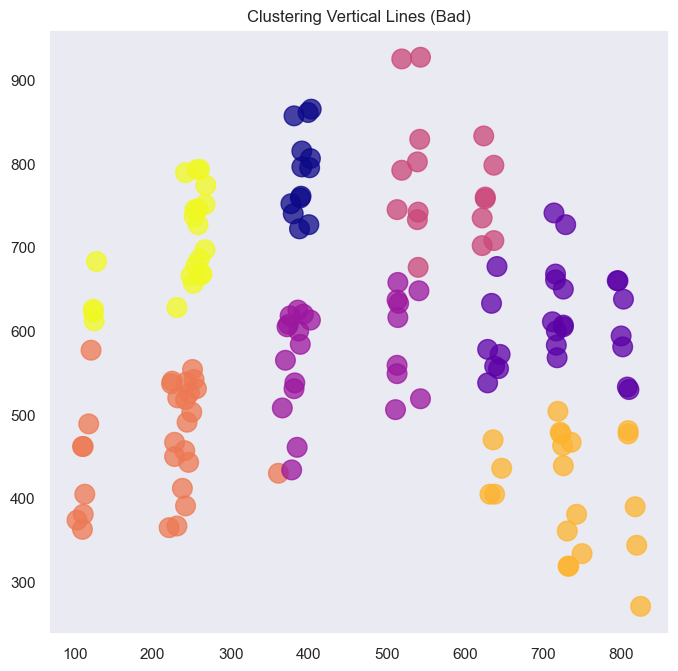

In [339]:
X = points1.copy()

y_pred_vertical_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X)

plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_vertical_lines, cmap='plasma_r', s=200, alpha=0.75)
plt.title("Clustering Vertical Lines (Bad)")
plt.show()

Divide the y component of the points by 10: Good

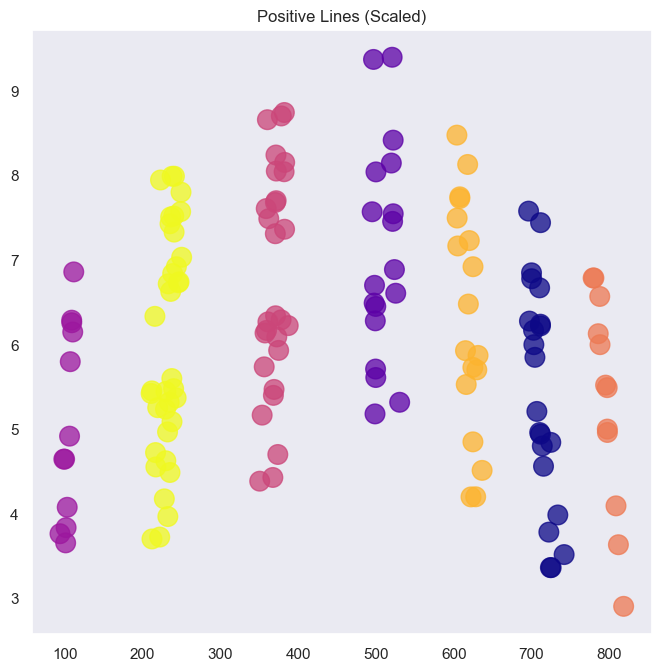

In [340]:
X = points1.copy()

# Let's Rotate the points by 60 degrees
theta = rotation_angles[0]*np.pi/180

# Define the rotation matrix
R = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]])

# Rotate the points
X_rotated = X @ R.T

X_rotated[:,1] /= 100

y_pred_vertical_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X_rotated)

plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], c=y_pred_vertical_lines, cmap='plasma_r', s=200, alpha=0.75)
plt.title("Positive Lines (Scaled)")
plt.show()

### Positive Lines

Default clustering result: Bad

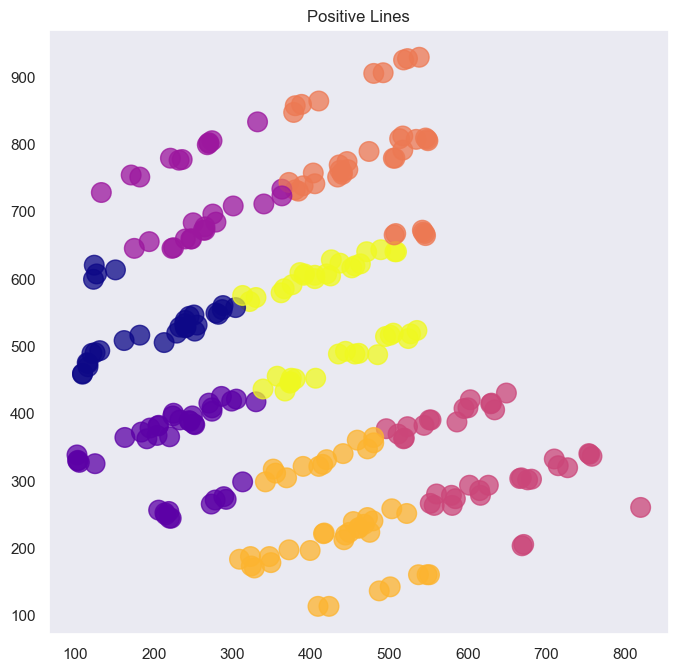

In [341]:
X = points2.copy()

y_pred_positive_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X)

plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_positive_lines, cmap='plasma_r', s=200, alpha=0.75)
plt.title("Positive Lines")
plt.show()

Rotate the points by -60: Now they're like vertical lines

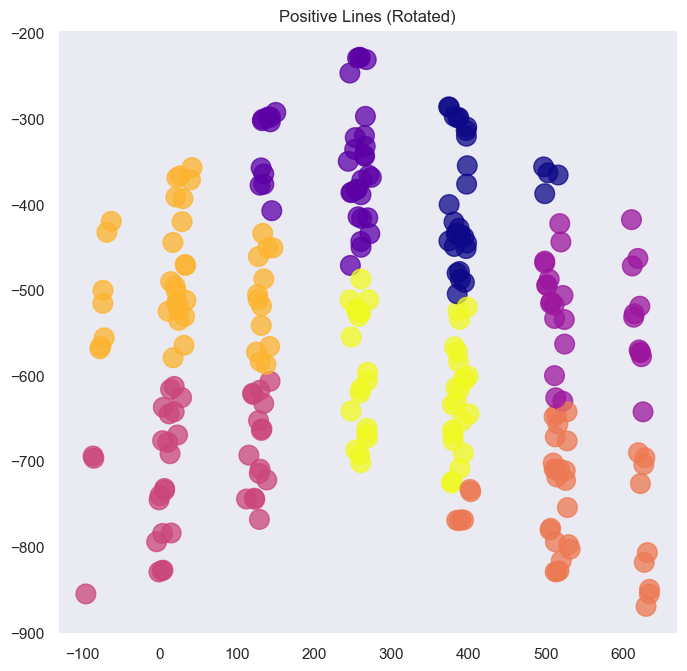

In [342]:
X = points2.copy()

# Let's Rotate the points by -60 degrees
theta = angle_limits[2]*np.pi/180

# Define the rotation matrix
R = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]])
    
# Rotate the points
X_rotated = X @ R.T

y_pred_positive_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X_rotated)

plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], c=y_pred_positive_lines, cmap='plasma_r', s=200, alpha=0.75)
plt.title("Positive Lines (Rotated)")
plt.show()

Divide the y component of the points by 10: Good

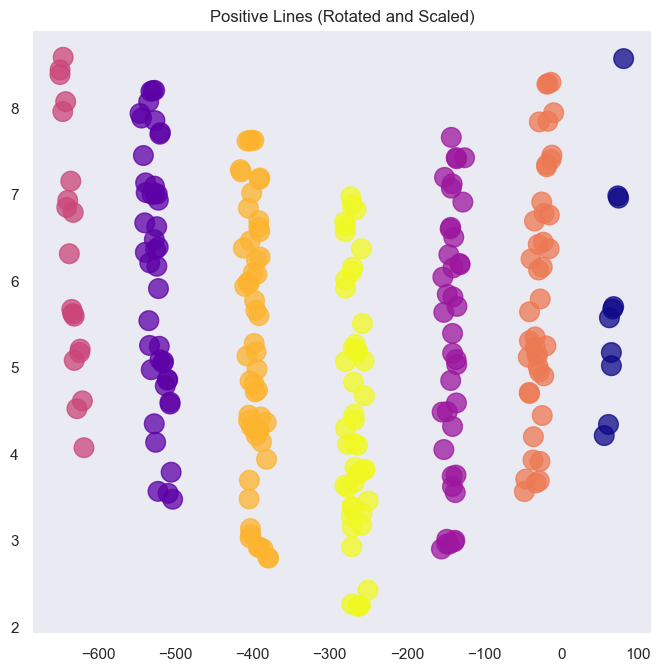

In [343]:
X = points2.copy()

# Let's Rotate the points by 60 degrees
theta = rotation_angles[1]*np.pi/180

# Define the rotation matrix
R = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]])

# Rotate the points
X_rotated = X @ R.T

X_rotated[:,1] /= 100

y_pred_positive_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X_rotated)

plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], c=y_pred_positive_lines, cmap='plasma_r', s=200, alpha=0.75)
plt.title("Positive Lines (Rotated and Scaled)")
plt.show()

### Negative Lines

Default clustering result: Bad

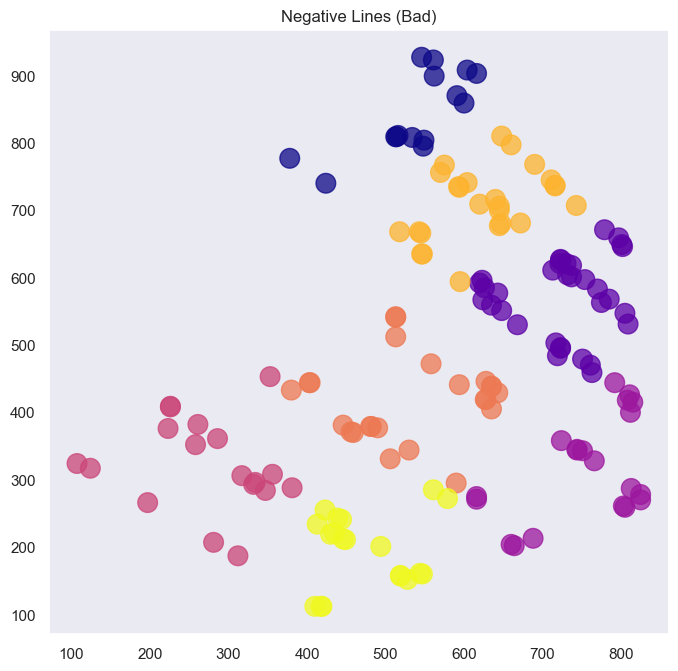

In [344]:
X = points3.copy()

y_pred_negative_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X)

plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_negative_lines, cmap='plasma_r', s=200, alpha=0.75)
plt.title("Negative Lines (Bad)")
plt.show()

Rotate the points by +60: Now they're like vertical lines

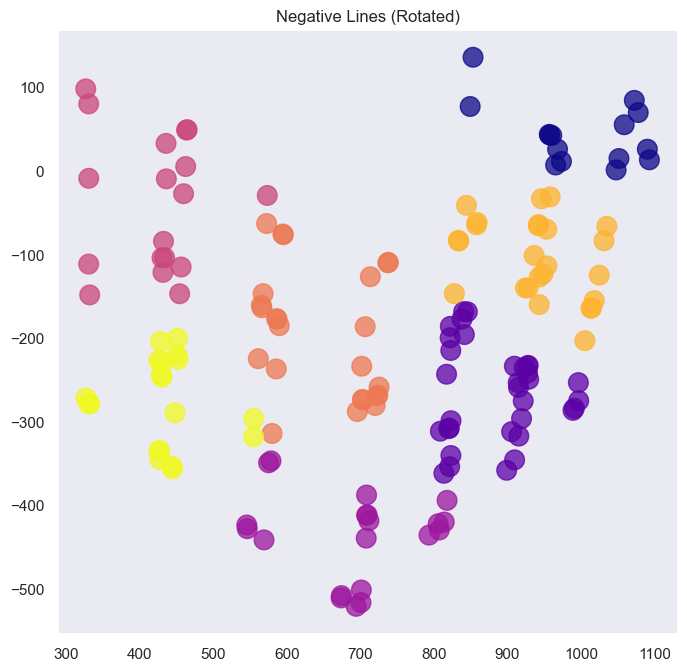

In [345]:
X = points3.copy()

# Let's Rotate the points by -60 degrees
theta = angle_limits[1]*np.pi/180

# Define the rotation matrix
R = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]])
    
# Rotate the points
X_rotated = X @ R.T

y_pred_negative_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X_rotated)

plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], c=y_pred_negative_lines, cmap='plasma_r', s=200, alpha=0.75)
plt.title("Negative Lines (Rotated)")
plt.show()

Divide the y component of the points by 10: Good

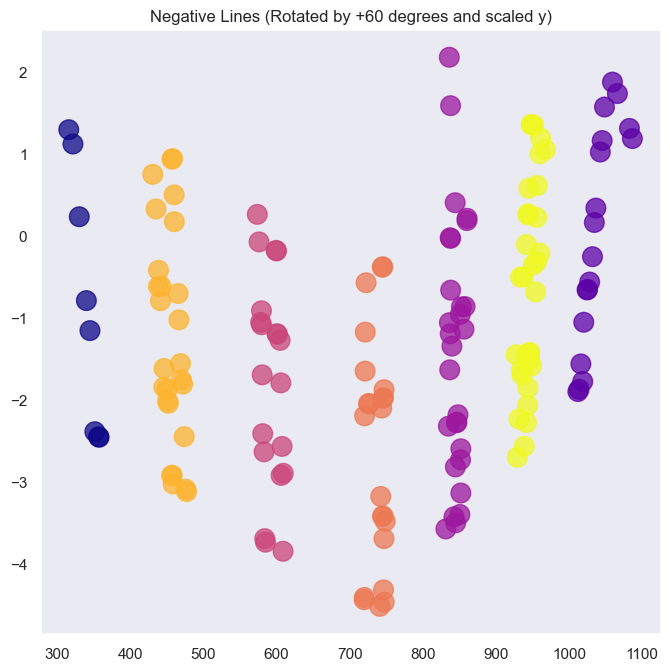

In [346]:
X = points3.copy()

# Let's Rotate the points by 60 degrees
theta = rotation_angles[2]*np.pi/180

# Define the rotation matrix
R = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]])

# Rotate the points
X_rotated = X @ R.T

X_rotated[:,1] /= 100

y_pred_negative_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X_rotated)

plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], c=y_pred_negative_lines, cmap='plasma_r', s=200, alpha=0.75)
plt.title("Negative Lines (Rotated by +60 degrees and scaled y)")
plt.show()

## Line Fitting

### Vertical Lines

Coefficients: 
 0.06471187591984603
Intercept: 
 83.83668062945772


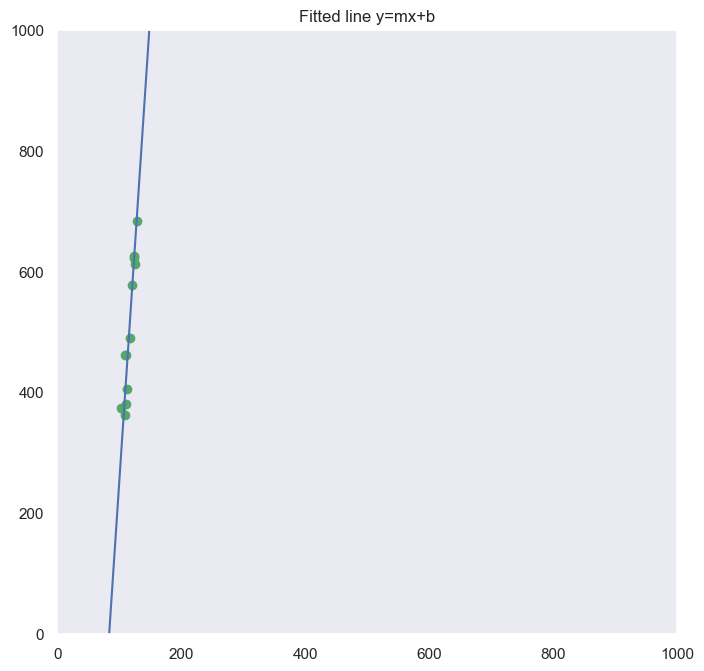

In [347]:
# Select only one cluster
cluster_id =4
X = points1.copy()[y_pred_vertical_lines==cluster_id]

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X[:,1].reshape(-1, 1), X[:,0])

# The coefficients
print("Coefficients: \n", regr.coef_[0])
print("Intercept: \n", regr.intercept_)

m = regr.coef_[0]
b = regr.intercept_

x = np.arange(0,img_1.shape[1])
y = m*x+b

plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(X[:, 0], X[:, 1], c='g', cmap='plasma_r')
plt.plot(y, x)
plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.title("Fitted line y=mx+b")

plt.show()


In [348]:
fitted_ms_all = []
fitted_bs_all = []
scalers_all = []

In [349]:
class GHD_Scaler:
    def __init__(self):
        pass

    def fit(self, X):
        pass

    def transform(self, X):
        return X

    def inverse_transform(self, X):
        return X


In [350]:
fitted_ms = []
fitted_bs = []
scalers = []

# vertical lines
for cluster_id in range(7):
    X = points1.copy()[y_pred_vertical_lines==cluster_id]
    scaler = GHD_Scaler()
    scaler.fit(X)
    X = scaler.transform(X)
    scalers.append(scaler)

    regr = LinearRegression()
    regr.fit(X[:,1].reshape(-1, 1), X[:,0])

    m = regr.coef_[0]
    b = regr.intercept_

    fitted_ms.append(m)
    fitted_bs.append(b)

fitted_ms_all.append(fitted_ms)
fitted_bs_all.append(fitted_bs)
scalers_all.append(scalers)

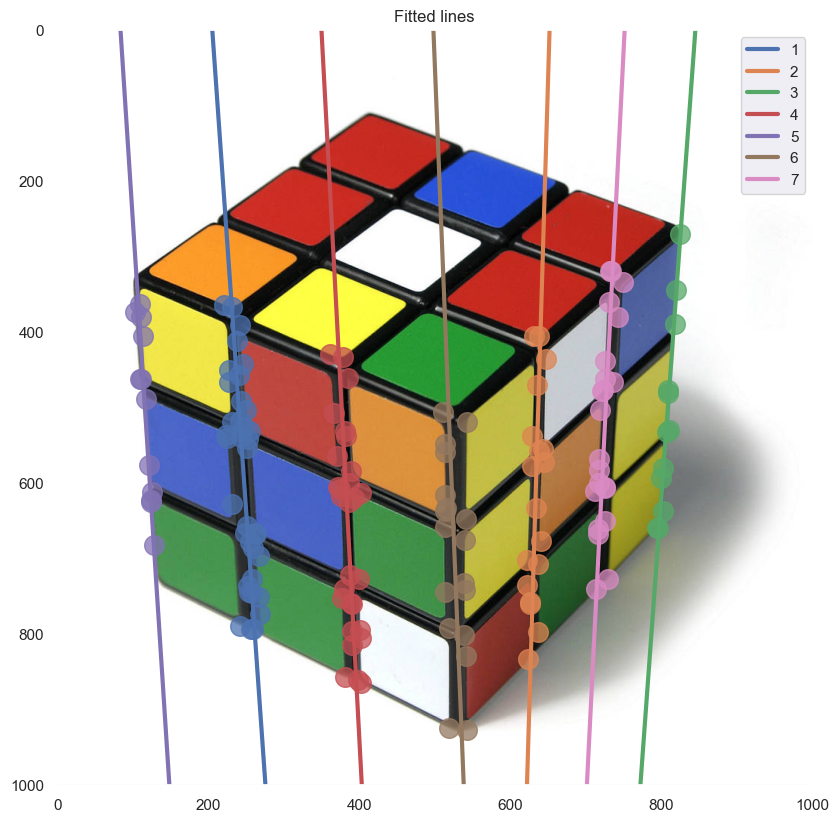

In [351]:
plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(img_1)
for cluster_id in range(7):
    # Get the points of this cluster
    X = points1.copy()[y_pred_vertical_lines==cluster_id]
    
    # Get the corresponding scaler
    scaler = scalers[cluster_id]

    # Calculate the points in the current line
    x = np.arange(0,img_1.shape[1])
    # Scale the x values so that they work with m and b
    x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
    y = fitted_ms[cluster_id]*x+fitted_bs[cluster_id]

    # Concatenate fitted line's x and y
    line_X = np.column_stack([y, x])
    
    # Inverse Scaler transform
    line_X = scaler.inverse_transform(line_X)

    plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r', s=200, alpha=0.75)
    plt.plot(line_X[:, 0], line_X[:, 1], linewidth=3)

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()


### Positive Lines

In [352]:
fitted_ms = []
fitted_bs = []
scalers = []

# Positive lines
for cluster_id in range(7):
    X = points2.copy()[y_pred_positive_lines==cluster_id]
    scaler = GHD_Scaler()
    scaler.fit(X)
    X = scaler.transform(X)
    scalers.append(scaler)

    regr = LinearRegression()
    regr.fit(X[:,0].reshape(-1, 1), X[:,1])

    m = regr.coef_[0]
    b = regr.intercept_

    fitted_ms.append(m)
    fitted_bs.append(b)

fitted_ms_all.append(fitted_ms)
fitted_bs_all.append(fitted_bs)
scalers_all.append(scalers)

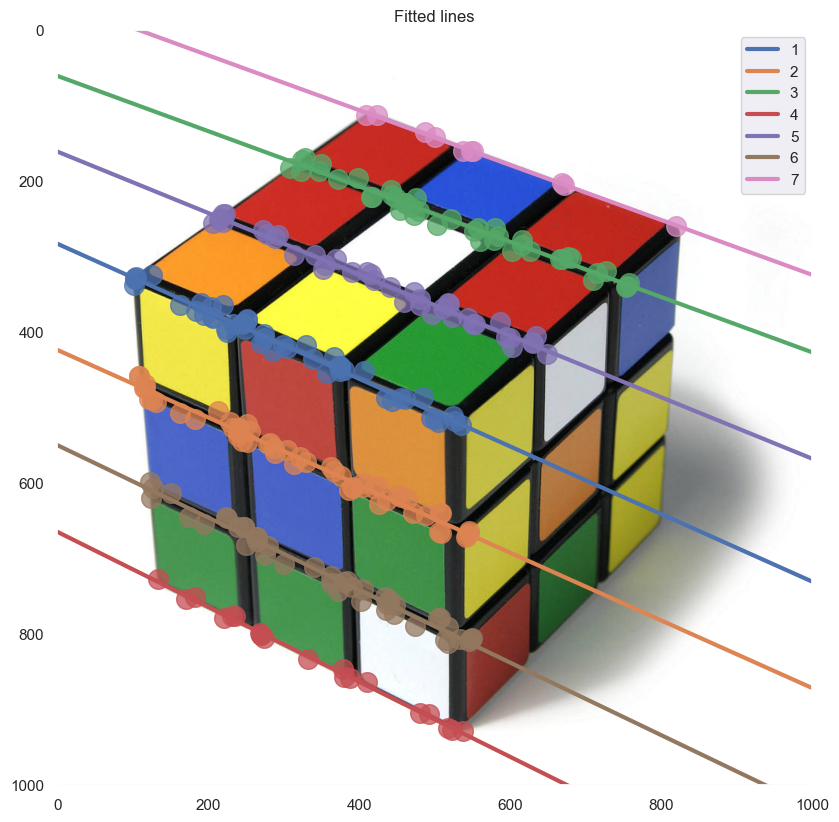

In [353]:
plt.figure(figsize=(10, 10), dpi=100)

plt.imshow(img_1)
for cluster_id in range(7):
    # Get the points of this cluster
    X = points2.copy()[y_pred_positive_lines==cluster_id]
    
    # Get the corresponding scaler
    scaler = scalers[cluster_id]

    # Calculate the points in the current line
    x = np.arange(0,img_1.shape[1])
    # Scale the x values so that they work with m and b
    x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
    y = fitted_ms[cluster_id]*x+fitted_bs[cluster_id]

    # Concatenate fitted line's x and y
    line_X = np.column_stack([x,y])
    
    # Inverse Scaler transform
    line_X = scaler.inverse_transform(line_X)

    plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r', s=200, alpha=0.75)
    plt.plot(line_X[:, 0], line_X[:, 1], linewidth=3)

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()


### Negative Lines

In [354]:
fitted_ms = []
fitted_bs = []
scalers = []

# Negative lines
for cluster_id in range(7):
    X = points3.copy()[y_pred_negative_lines==cluster_id]
    scaler = GHD_Scaler()
    scaler.fit(X)
    X = scaler.transform(X)
    scalers.append(scaler)

    regr = LinearRegression()
    regr.fit(X[:,0].reshape(-1, 1), X[:,1])

    m = regr.coef_[0]
    b = regr.intercept_

    fitted_ms.append(m)
    fitted_bs.append(b)

fitted_ms_all.append(fitted_ms)
fitted_bs_all.append(fitted_bs)
scalers_all.append(scalers)

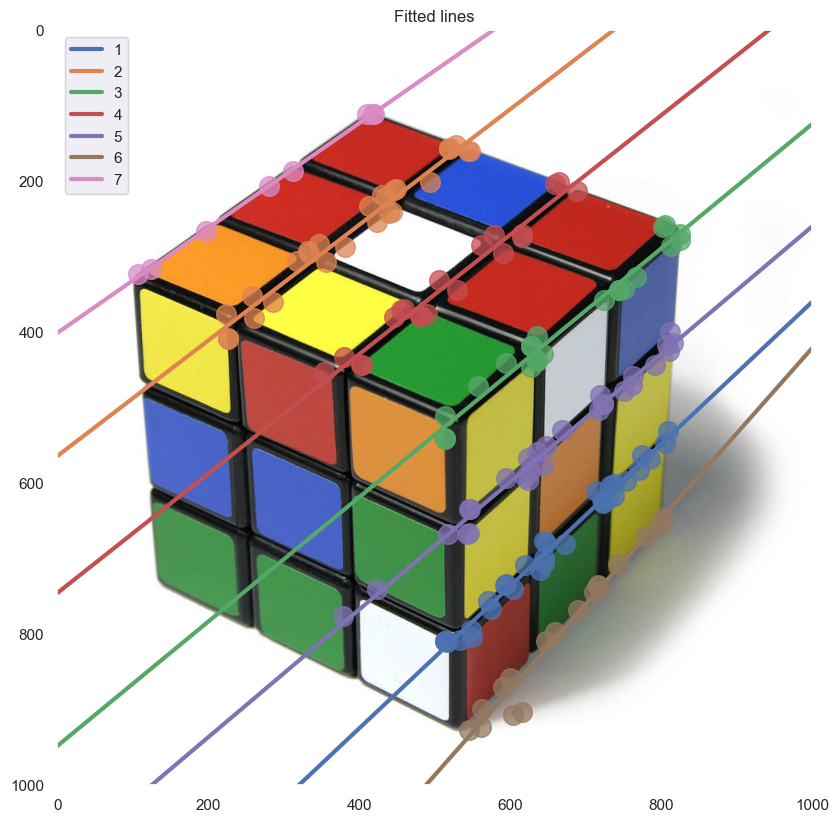

In [355]:
plt.figure(figsize=(10, 10), dpi=100)

plt.imshow(img_1)
for cluster_id in range(7):
    # Get the points of this cluster
    X = points3.copy()[y_pred_negative_lines==cluster_id]
    
    # Get the corresponding scaler
    scaler = scalers[cluster_id]

    # Calculate the points in the current line
    x = np.arange(0,img_1.shape[1])
    # Scale the x values so that they work with m and b
    x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
    y = fitted_ms[cluster_id]*x+fitted_bs[cluster_id]

    # Concatenate fitted line's x and y
    line_X = np.column_stack([x,y])
    
    # Inverse Scaler transform
    line_X = scaler.inverse_transform(line_X)

    plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r', s=200, alpha=0.75)
    plt.plot(line_X[:, 0], line_X[:, 1], linewidth=3)

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()


### All together

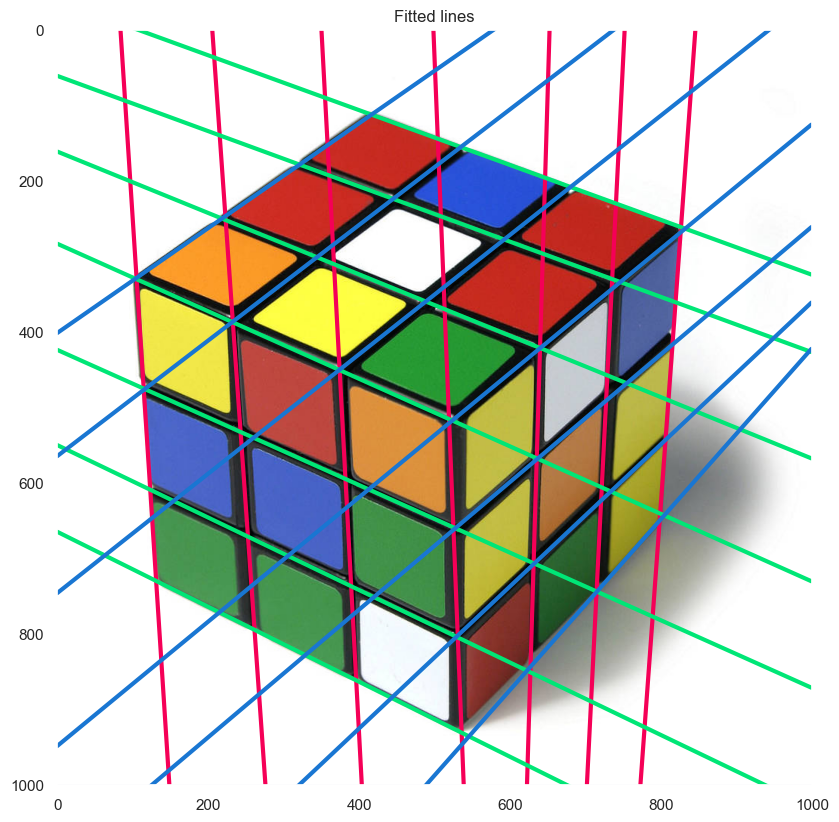

In [356]:
plt.figure(figsize=(10, 10), dpi=100)

plt.imshow(img_1)

for i in range(3):
    for cluster_id in range(7):
        # Get the points of this cluster
        if i==0:
            X = points1.copy()[y_pred_vertical_lines==cluster_id]
        elif i==1:
            X = points2.copy()[y_pred_positive_lines==cluster_id]
        elif i==2:
            X = points3.copy()[y_pred_negative_lines==cluster_id]
        
        # Get the corresponding scaler
        scaler = scalers_all[i][cluster_id]

        # Calculate the points in the current line
        x = np.arange(0,img_1.shape[1])

        # Scale the x values so that they work with m and b
        x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
        y = fitted_ms_all[i][cluster_id]*x+fitted_bs_all[i][cluster_id]

        # Concatenate fitted line's x and y
        if i==0:
            line_X = np.column_stack([y,x])
        else:
            line_X = np.column_stack([x,y])
        
        # Inverse Scaler transform
        line_X = scaler.inverse_transform(line_X)

        # plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r')
        plt.plot(line_X[:, 0], line_X[:, 1], c=colors_01[i], linewidth=3)

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
# plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()


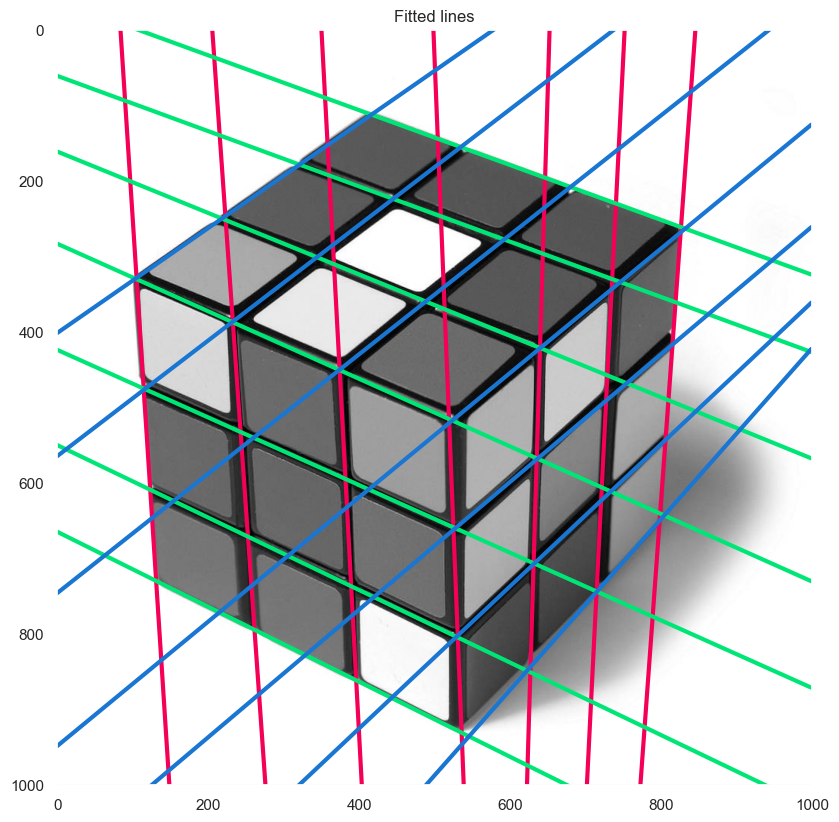

In [357]:
plt.figure(figsize=(10, 10), dpi=100)

plt.imshow(img_1_gray_rgb)

for i in range(3):
    for cluster_id in range(7):
        # Get the points of this cluster
        if i==0:
            X = points1.copy()[y_pred_vertical_lines==cluster_id]
        elif i==1:
            X = points2.copy()[y_pred_positive_lines==cluster_id]
        elif i==2:
            X = points3.copy()[y_pred_negative_lines==cluster_id]
        
        # Get the corresponding scaler
        scaler = scalers_all[i][cluster_id]

        # Calculate the points in the current line
        x = np.arange(0,img_1.shape[1])

        # Scale the x values so that they work with m and b
        x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
        y = fitted_ms_all[i][cluster_id]*x+fitted_bs_all[i][cluster_id]

        # Concatenate fitted line's x and y
        if i==0:
            line_X = np.column_stack([y,x])
        else:
            line_X = np.column_stack([x,y])
        
        # Inverse Scaler transform
        line_X = scaler.inverse_transform(line_X)

        # plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r')
        plt.plot(line_X[:, 0], line_X[:, 1], c=colors_01[i], linewidth=3)

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
# plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()


In [369]:
def plot_intersection_points_on_cube(fitted_ms_all, fitted_bs_all, scalers_all,  img_gray_rgb, direction_list=[1,2], debug=True, c="g"):
    points_on_the_face = []

    if debug:
        plt.figure(figsize=(8, 8), dpi=100)
        plt.imshow(img_gray_rgb)

    # Sort lines from left to right and bottom to top
    msi = fitted_ms_all[direction_list[0]]
    bsi = fitted_bs_all[direction_list[0]]
    scaler_i = scalers_all[direction_list[0]]

    # Sort lines by b
    if direction_list[0] == 0 and direction_list[1] == 2:
        sorted_indices_i = np.argsort(bsi)[::-1]
    elif direction_list[0] == 0 and direction_list[1] == 1:
        sorted_indices_i = np.argsort(bsi)
    else:
        sorted_indices_i = np.argsort(bsi)

    msi = np.array(msi)[sorted_indices_i]
    bsi = np.array(bsi)[sorted_indices_i]
    scaler_i = np.array(scaler_i)[sorted_indices_i]
    
    msj = fitted_ms_all[direction_list[1]]
    bsj = fitted_bs_all[direction_list[1]]
    scaler_j= scalers_all[direction_list[1]]

    # sort lines by b
    if direction_list[0] == 0 and direction_list[1] == 2:
        sorted_indices_j = np.argsort(bsj)[::-1]
    elif direction_list[0] == 0 and direction_list[1] == 1:
        sorted_indices_j = np.argsort(bsj)[::-1]
    else:
        sorted_indices_j = np.argsort(bsj)

    msj = np.array(msj)[sorted_indices_j]
    bsj = np.array(bsj)[sorted_indices_j]
    scaler_j = np.array(scaler_j)[sorted_indices_j]


    # first 4 lines of dir_a
    for i in range(4):
        # first 4 lines of dir_b
        for j in range(4):
            m1 = msi[i]
            b1 = bsi[i]
            m2 = msj[j]
            b2 = bsj[j]
            if direction_list[0] == 0:
                b1 = -b1/m1
                m1 = 1/m1
            
            x = (b2-b1)/(m1-m2)
            y = m1*x+b1

            points_on_the_face.append([x,y])

            if debug:
                plt.scatter([x], [y], c=c)

    if debug:
        plt.ylim([0,img_gray_rgb.shape[0]])
        plt.xlim([0,img_gray_rgb.shape[1]])
        plt.gca().invert_yaxis()
        plt.title("Fitted lines")

        plt.show()

    return points_on_the_face


In [359]:
# def plot_lines_on_cube(points_1, points_2, points_3, fitted_ms_all, fitted_bs_all, scalers_all,  img_gray_rgb, y_pred_1, y_pred_2, y_pred_3, direction_list=[0,1,2], n_clusters=7):
#     plt.figure(figsize=(6, 6))
#     plt.imshow(img_gray_rgb)

#     for i in direction_list:
#         for cluster_id in range(n_clusters):
#             # Get the points of this cluster
#             if i==0:
#                 X = points_1.copy()[y_pred_1==cluster_id]
#             elif i==1:
#                 X = points_2.copy()[y_pred_2==cluster_id]
#             elif i==2:
#                 X = points_3.copy()[y_pred_3==cluster_id]
            
#             # Get the corresponding scaler
#             scaler = scalers_all[i][cluster_id]

#             # Calculate the points in the current line
#             x = np.arange(0,img_gray_rgb.shape[1])

#             # Scale the x values so that they work with m and b
#             x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
#             y = fitted_ms_all[i][cluster_id]*x+fitted_bs_all[i][cluster_id]

#             # Concatenate fitted line's x and y
#             if i==0:
#                 # if vertical: x=my+b
#                 line_X = np.column_stack([y,x])
#             else:
#                 # else: y=mx+b
#                 line_X = np.column_stack([x,y])
            
#             # Inverse Scaler transform
#             line_X = scaler.inverse_transform(line_X)

#             plt.plot(line_X[:, 0], line_X[:, 1], c=colors_01[i], linewidth=1.5)

#     plt.ylim([0,img_gray_rgb.shape[0]])
#     plt.xlim([0,img_gray_rgb.shape[1]])
#     plt.gca().invert_yaxis()
#     plt.title("Fitted lines")

#     plt.show()

In [360]:
def display_reconstructed_faces(reconstructed_faces):
    faces_names = ["Left", "Right", "Top"]
    for f in range(3):
        disp(reconstructed_faces[f],  s=3, title=faces_names[f])

In [361]:
img_gray = img_1_gray
img = img_1
img_gray_rgb = np.repeat(img_gray[:, :, None], 3, 2)

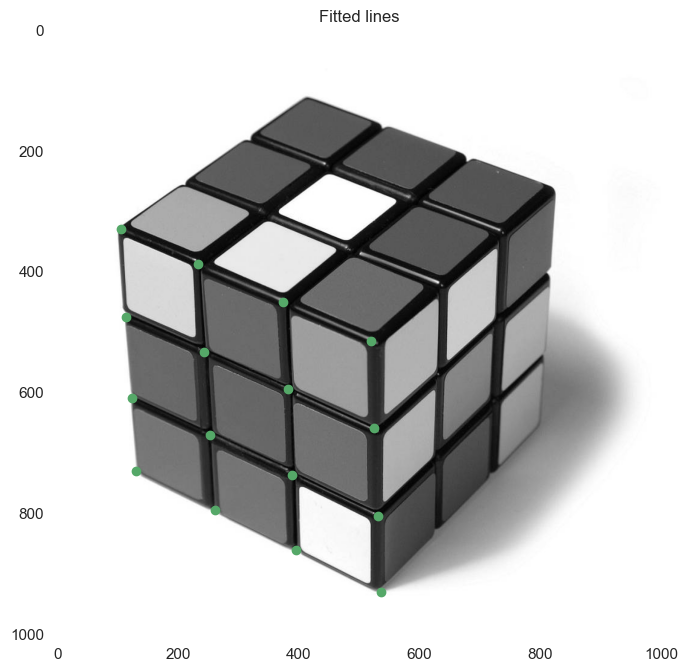

In [370]:
points_on_left_face = plot_intersection_points_on_cube(
    fitted_ms_all, fitted_bs_all, scalers_all,  img_gray_rgb,
    direction_list=[0, 1], debug=True)


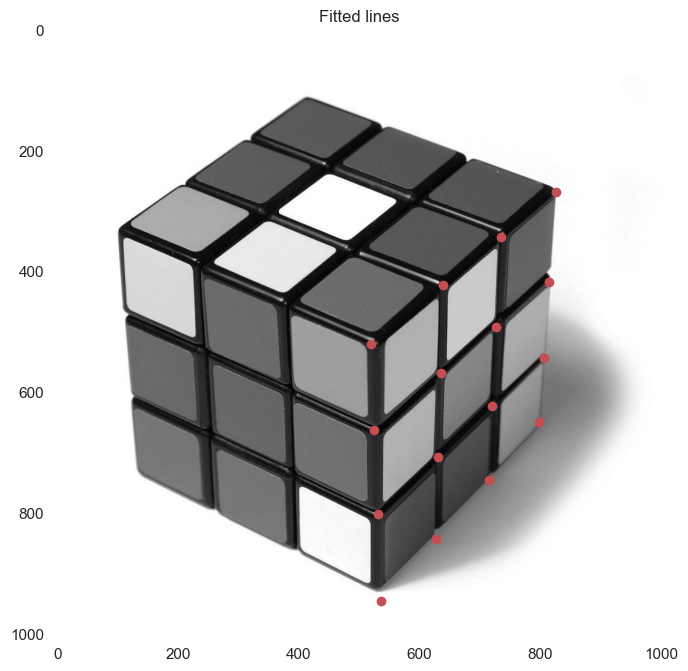

In [372]:

points_on_right_face = plot_intersection_points_on_cube(
    fitted_ms_all, fitted_bs_all, scalers_all,  img_gray_rgb,
    direction_list=[0, 2], debug=True, c='r')


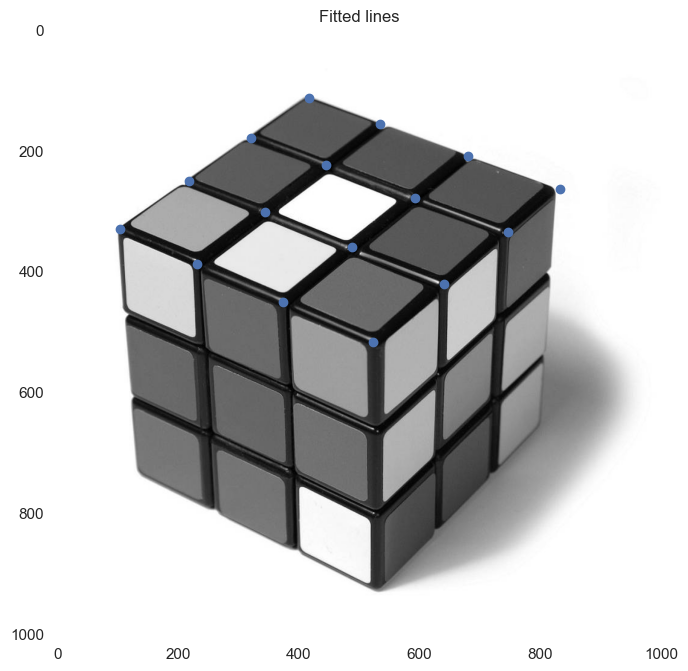

In [373]:

points_on_top_face = plot_intersection_points_on_cube(
    fitted_ms_all, fitted_bs_all, scalers_all,  img_gray_rgb,
    direction_list=[1, 2], debug=True, c='b')


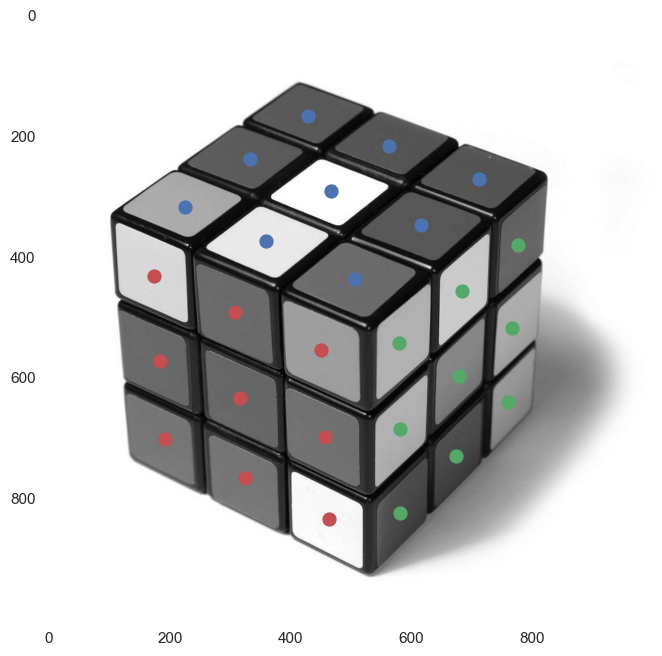

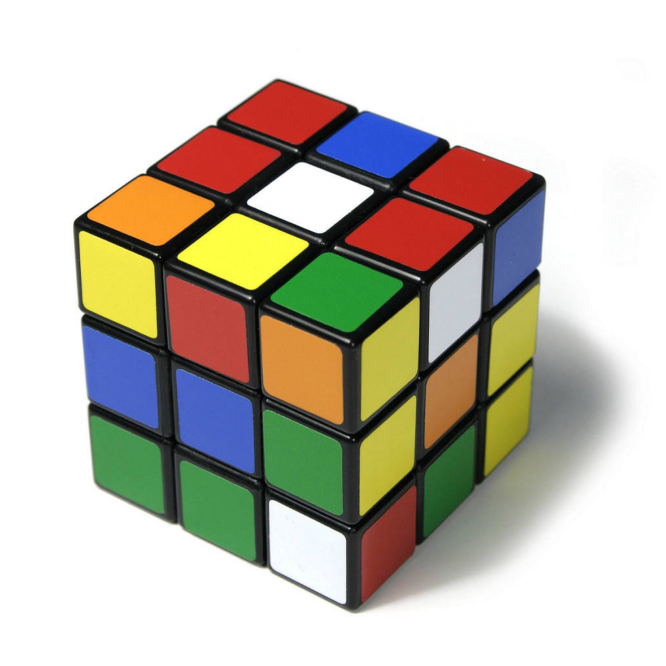

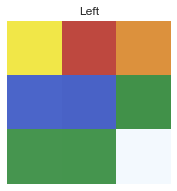

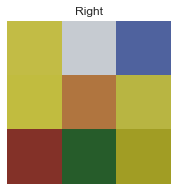

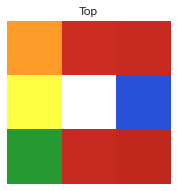

In [375]:


# 11. Find face centers
points_left = np.array(points_on_left_face)
points_right = np.array(points_on_right_face)
points_top = np.array(points_on_top_face)

face_indices = [
    [2, 3, 7, 6], [6, 7, 11, 10], [10, 11, 15, 14],
    [1, 2, 6, 5], [5, 6, 10, 9], [9, 10, 14, 13],
    [0, 1, 5, 4], [4, 5, 9, 8], [8, 9, 13, 12]
]

face_centers = [[], [], []]

plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(img_gray_rgb)

for face in face_indices:
    face_center = (points_left[face[0]] + points_left[face[1]] +
                points_left[face[2]] + points_left[face[3]]) / 4
    face_centers[0].append(face_center)

    plt.scatter([face_center[0]], [face_center[1]], c='r', s=86)

for face in face_indices:
    face_center = (points_right[face[0]] + points_right[face[1]] +
                points_right[face[2]] + points_right[face[3]]) / 4
    face_centers[1].append(face_center)

    plt.scatter([face_center[0]], [face_center[1]], c='g', s=86)

for face in face_indices:
    face_center = (points_top[face[0]] + points_top[face[1]] +
                points_top[face[2]] + points_top[face[3]]) / 4
    face_centers[2].append(face_center)

    plt.scatter([face_center[0]], [face_center[1]], c='b', s=86)

# 12. Extract face colors
reconstructed_faces = []
faces_names = ["Left", "Right", "Top"]

disp(img)

for f in range(3):
    reconstructed_face = np.zeros((3, 3, 3), dtype=np.uint8)
    for i in range(9):
        x, y = face_centers[f][i]
        x, y = int(x), int(y)
        w = 40
        mean_color = img[y-w//2:y+w//2, x-w//2:x +
                        w//2].mean(axis=(0, 1)).astype(np.uint8)
        reconstructed_face[i//3, i % 3, :] = mean_color

    reconstructed_faces.append(reconstructed_face)
    
# Fix face orientations
# Right face
reconstructed_faces[1] = np.flip(reconstructed_faces[1], axis=1)
# Top face
reconstructed_faces[2] = np.flip(reconstructed_faces[2], axis=1)
reconstructed_faces[2] = np.flip(reconstructed_faces[2], axis=0)

display_reconstructed_faces(reconstructed_faces)